In [1]:
import matplotlib.pyplot as plt
import matplotlib
import wandb
from rliable import library as rly
from rliable import metrics
from rliable import plot_utils
import seaborn as sns
import numpy as np
import os

from utils import *

/home/mbortkie/miniconda3/envs/c_r_l/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
plt.rcParams["legend.title_fontsize"] = "large"
plt.rcParams.update({'font.size': 12})

matplotlib.rc("xtick", labelsize=48)
matplotlib.rc("ytick", labelsize=48)

In [3]:
# Initialize the wandb API
api = wandb.Api()

# Define your project and entity (replace with your specific values)
entity = "cl-probing"  # e.g., your username or team name
project = "logsumexp_penalty"  # e.g., your project name
figures_path = f"./figures/{project}"
os.makedirs(figures_path, exist_ok=True)
take_x_seeds = 8

In [4]:
# TODO: wait for 0.0

exp_names = [
    "ant_l_symmetric_infonce_ef_l2_p_0.0",
    "ant_l_symmetric_infonce_ef_l2_p_0.01",
    "ant_l_symmetric_infonce_ef_l2_p_0.1",
    "ant_l_symmetric_infonce_ef_l2",
    "ant_l_symmetric_infonce_ef_l2_p_1",
]

exp_names_mapping = {
    "ant_l_symmetric_infonce_ef_l2_p_0.0": "Penalty coef = 0.0",
    "ant_l_symmetric_infonce_ef_l2_p_0.01": "Penalty coef = 0.01",
    "ant_l_symmetric_infonce_ef_l2_p_0.1": "Penalty coef = 0.1",
    "ant_l_symmetric_infonce_ef_l2": "Penalty coef = 0.1",
    "ant_l_symmetric_infonce_ef_l2_p_1": "Penalty coef = 1",
}

In [5]:
env_title_mapping = {
    "ant_ball": "Ant Soccer",
    "ant": "Ant",
    "ant_u_maze": "Ant U-Maze",
    "ant_big_maze": "Ant Big Maze"
}
metric_to_metric_label_dict = {
    "eval/episode_success": "Reward",
    "eval/episode_success_any": "Success rate",
}

# Results for all envs

In [6]:
metrics_ = ["eval/episode_success_any", "eval/episode_success"]
single_env=False


In [7]:
# Define filters for the run config (replace with your specific filters)
filters = {
    "config.batch_size": 256,  # example filter, modify as needed
    "config.exp_name": {"$in": exp_names},
    "config.env_name": {"$in": list(env_title_mapping.keys())},
    "state": "finished",
}

# Fetch the runs from the API
runs = api.runs(path=f"{entity}/{project}", filters=filters)

In [8]:
runs_new = []
for run in runs:
    if not run.id in ["5slmt9c6", "s8knmfp6"]:
        runs_new.append(run)
runs=runs_new

In [9]:
len(runs)

158

Penalty coef = 0.0, Ant Soccer
(8, 1, 50)
Penalty coef = 0.01, Ant Soccer
(8, 1, 50)
Penalty coef = 0.1, Ant Soccer
(8, 1, 1, 50)
Penalty coef = 0.1, Ant Soccer
(8, 1, 1, 50)
Penalty coef = 1, Ant Soccer
(8, 1, 50)
Penalty coef = 0.0, Ant
(8, 1, 50)
Penalty coef = 0.01, Ant
(8, 1, 50)
Penalty coef = 0.1, Ant
(8, 1, 1, 50)
Penalty coef = 0.1, Ant
(8, 1, 1, 50)
Penalty coef = 1, Ant
(8, 1, 50)
Penalty coef = 0.0, Ant U-Maze
(8, 1, 50)
Penalty coef = 0.01, Ant U-Maze
(8, 1, 50)
Penalty coef = 0.1, Ant U-Maze
(8, 1, 1, 50)
Penalty coef = 0.1, Ant U-Maze
(8, 1, 1, 50)
Penalty coef = 1, Ant U-Maze
(8, 1, 50)
Penalty coef = 0.0, Ant Big Maze
(8, 1, 50)
Penalty coef = 0.01, Ant Big Maze
(8, 1, 50)
Penalty coef = 0.1, Ant Big Maze
(8, 1, 1, 50)
Penalty coef = 0.1, Ant Big Maze
(8, 1, 1, 50)
Penalty coef = 1, Ant Big Maze
(8, 1, 50)
Penalty coef = 0.0, Ant Soccer
(8, 1, 50)
Penalty coef = 0.01, Ant Soccer
(8, 1, 50)
Penalty coef = 0.1, Ant Soccer
(8, 1, 1, 50)
Penalty coef = 0.1, Ant Soccer
(8, 

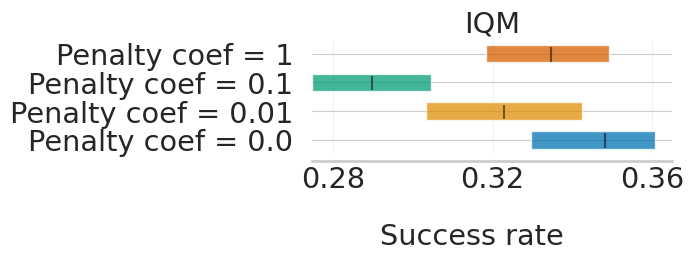

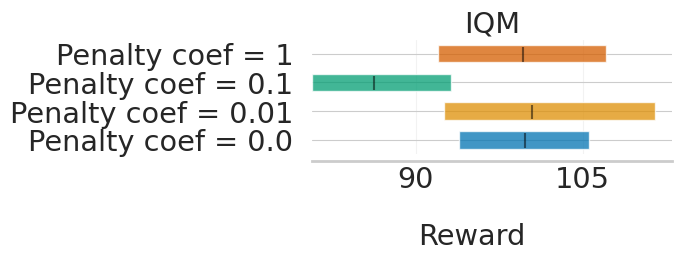

In [10]:
for metric in metrics_:
    metric_label = metric_to_metric_label_dict[metric]
    data = aggregate_data_from_wandb(
        runs, metric, exp_names, exp_names_mapping, env_title_mapping, take_x_seeds, single_env, download_again=False
    )
    
    # Smoothing
    for key, item in data.items():
        data[key] = np.apply_along_axis(moving_average_smoothing, axis=-1, arr=item) 
    
    data_flattened = {key: np.mean(elem[:,:, -10:], axis=-1) for key, elem in data.items()}
    
    
    aggregate_func = lambda x: np.array(
    [
        # metrics.aggregate_median(x),
        metrics.aggregate_iqm(x),
        # metrics.aggregate_mean(x),
    ]
    )
    aggregate_scores, aggregate_score_cis = rly.get_interval_estimates(
        data_flattened, aggregate_func, reps=500
    )
    fig, axes = plot_utils.plot_interval_estimates(
        aggregate_scores,
        aggregate_score_cis,
        # metric_names=["Median", "IQM", "Mean"],
        metric_names=["IQM"],
        algorithms=list(data.keys()),
        xlabel=f"{metric_label}",
        grid_alpha=0.4,
        max_ticks=3,
        subfigure_width=4,
        xlabel_y_coordinate=-0.5,
    )
    plt.subplots_adjust(wspace=0.2, left=0.0)
    
    if isinstance(axes, matplotlib.axes._axes.Axes):
        axes = [axes]
        
    # for ax in axes:
    #     if metric_label == "Success rate":
    #         ax.set_xlim((0.4, 0.7))
    #     else:
    #         ax.set_xlim((100, 280))
    
    plt.savefig(
        os.path.join(figures_path, f"{metric_label}_all.pdf"), bbox_inches="tight"
    )
        
    

In [11]:
data.keys()

dict_keys(['Penalty coef = 0.0', 'Penalty coef = 0.01', 'Penalty coef = 0.1', 'Penalty coef = 1'])

In [12]:
data['Penalty coef = 0.0'].shape

(8, 4, 50)